In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs 

In [11]:
# 加えてやりたいこと
# dwntwn実行後はovlpが128から134に増加した
# ovlpでNoMASKになる都市とそうでない都市を判別する
# NoMASKはlndmsk問題によって発生している→修正(307)都市
# MASKは作って，CAMA推定は行わないようにするのが良いと思われる

In [12]:
def geography(one, twho, three, four):
    #
    a = 2160
    b = 4320
    gl5shape = (a, b)
    #
    upperindex = (90-four)*12
    lowerindex = (90-three)*12
    leftindex = (180+one)*12
    rightindex = (180+two)*12
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (one, two, three, four)  
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

In [13]:
### to be changed ###
root_dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08'

#name of the camacity file
cmct_name = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_lst_/create_text/camacity_first.txt'

In [ ]:
vlddir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_'
moddir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/dwn_msk_'
lowdir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/low_msk_'
savedir = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat'
savetext_path = f'{savedir}/cty_lst_/removed_overlap.txt'
save_path = f'{savedir}/cty_msk_/city_clrd0000.gl5'

canvas = np.zeros((2160, 4320))

for cty_ind in range(1, 1861):
    
    vld_path = f'{vlddir}/city_{cty_ind:08}.gl5'
    dwn_path = f'{moddir}/city_kj_{cty_ind:08}.gl5'
    if not os.path.exists(vld_path):
        
        low_path = f'{lowdir}/city_kj_{cty_ind:08}.gl5'
        if not os.path.exists(low_path):
            print(f"{cty_ind} is NoMASK")
            continue
        else:
            msk_path =  low_path
            
    elif os.path.exists(dwn_path):
        msk_path = dwn_path

    else:
        msk_path = vld_path

    ###################################################################
    # JOB
    ###################################################################
    # maskの値を取得
    mask = np.fromfile(msk_path, dtype='float32').reshape(2160, 4320)
        
    # maskが0でない場所のインデックスを取得(tuple形式)
    non_zero_coords = np.where(mask != 0)
    
    # キャンバスのmask位置に存在する値を取得
    settled_values = canvas[non_zero_coords]
    
    # ユニークな値は?
    unq = np.unique(settled_values)
    unq_non_zero = unq[unq > 0]

    # overlap判定
    if np.sum(settled_values) > 0:
        # 重複削除
        for j in range(len(mask)):
            for k in range(len(mask[0])):
                if mask[j,k] != 0:
                    if canvas[j,k] != 0:
                        mask[j,k] = 0
        non_zero_update = np.where(mask != 0)
        grid_num = np.sum(mask)

        # update canvas
        canvas[non_zero_update] = cty_ind

        # save text
        if not os.path.exists(savetext_path):
            with open(savetext_path, 'w') as file:
                file.write(f"{cty_ind}|{unq_non_zero}|{grid_num}")
        else:
            with open(savetext_path, 'a') as file:
                file.write(f"{cty_ind}|{unq_non_zero}|{grid_num}")

        # remove or modify
        if grid_num == 0:
            print(f'{cty_ind} is removed')
        else:
            print(f'{cty_ind} is modified')

        # save mask
        save_path = f'{root_dir}/camacity/dat/ovlpmsk_/city_kj_{cty_ind:08}.gl5'
        mask.astype(np.float32).tofile(save_path)
        print(f"{save_path} saved")
        
    else:
        # update canvas
        canvas[non_zero_coords] = cty_ind

canvas.astype(np.float32).tofile(save_path)

43 is modified
/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/ovlpmsk_/city_kj_00000043.gl5 saved
44 is removed
/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/ovlpmsk_/city_kj_00000044.gl5 saved
122 is modified
/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/ovlpmsk_/city_kj_00000122.gl5 saved


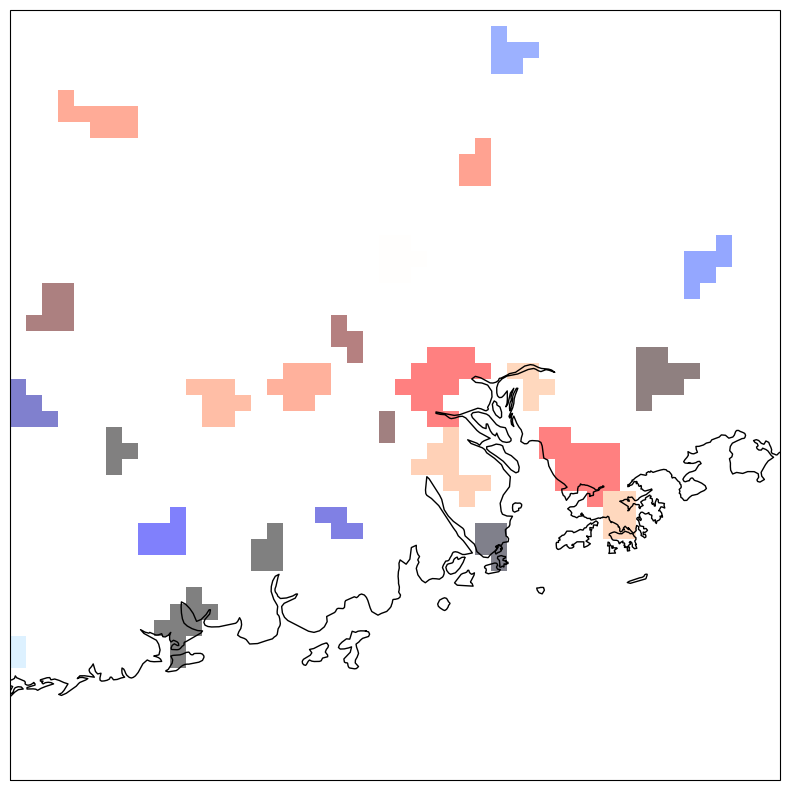

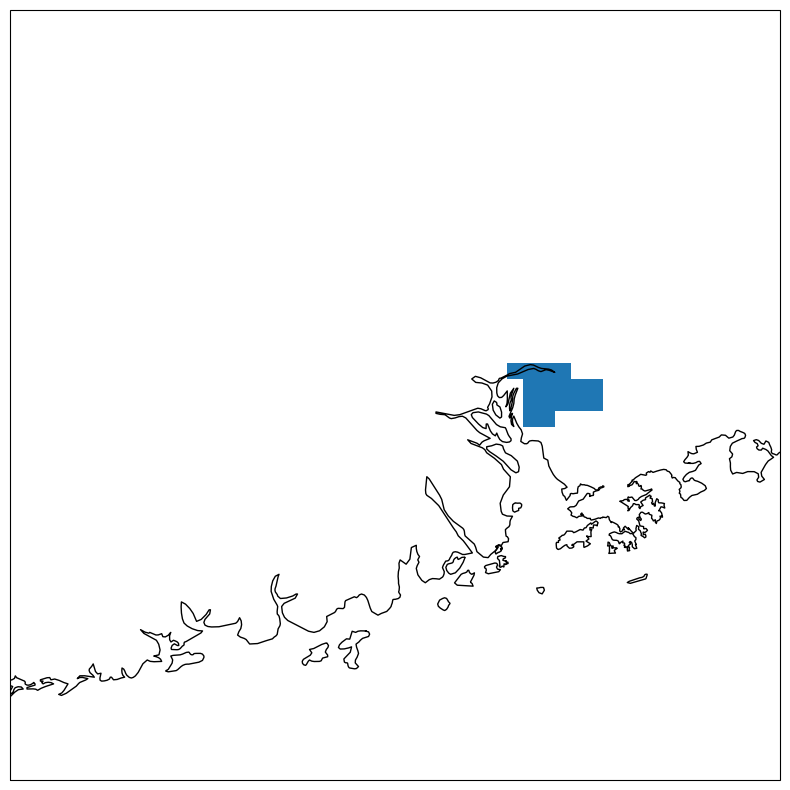

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/ovlpmsk_/city_kj_00000042.gl5'

In [31]:
#drawings
city_nb = 42 #Dongguan
one = 111
two = 115
three = 21
four = 25
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(one, two, three, four)


#ref
ref_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_msk_/city_clrd0000.gl5'
ref = np.fromfile(ref_path, dtype='float32').reshape(2160, 4320)

ref_cropped = ref[upperindex:lowerindex, leftindex:rightindex]
ref_masked = np.ma.masked_where(ref_cropped==0, ref_cropped)

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
im = ax.imshow(ref_masked,
               extent=img_extent, transform=projection, cmap='flag', alpha=0.5)
ax.coastlines()
plt.show()


#before removal
ctyclr_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/dwn_msk_/city_kj_{city_nb:08}.gl5'
#ctyclr_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/vld_cty_/city_{city_nb:08}.gl5'
ctyclr_gl5 = np.fromfile(ctyclr_path, dtype='float32').reshape(2160, 4320)
ctyclr_cropped = ctyclr_gl5[upperindex:lowerindex, leftindex:rightindex]
ctyclr_masked = np.ma.masked_where(ctyclr_cropped==0, ctyclr_cropped)

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
im = ax.imshow(ctyclr_masked,
               extent=img_extent, transform=projection, cmap='tab20')
ax.coastlines()
plt.show()


#after removal
ctyclr_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/ovlpmsk_/city_kj_{city_nb:08}.gl5'
ctyclr_gl5 = np.fromfile(ctyclr_path, dtype='float32').reshape(2160, 4320)
ctyclr_cropped = ctyclr_gl5[upperindex:lowerindex, leftindex:rightindex]
ctyclr_masked = np.ma.masked_where(ctyclr_cropped==0, ctyclr_cropped)

projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
im = ax.imshow(ctyclr_masked,
               extent=img_extent, transform=projection, cmap='tab20')
ax.coastlines()
plt.show()


mod = ref + ctyclr_gl5*city_nb
mod_cropped = mod[upperindex:lowerindex, leftindex:rightindex]
mod_masked = np.ma.masked_where(mod_cropped==0, mod_cropped)
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(projection=projection)
im = ax.imshow(mod_masked,
               extent=img_extent, transform=projection, cmap='flag', alpha=0.5)
ax.coastlines()
plt.show()